In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import cv2

In [4]:
style.use("ggplot")

on # 0, epsilon:0.9
3000 ep mean nan


/home/lauradata/.pyenv/versions/3.8.12/envs/reinforcement_learning/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lauradata/.pyenv/versions/3.8.12/envs/reinforcement_learning/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 3000, epsilon:0.49390083359356435
3000 ep mean -172.656
on # 6000, epsilon:0.27104225936046566
3000 ep mean -112.858
on # 9000, epsilon:0.14874221981913022
3000 ep mean -84.23466666666667
on # 12000, epsilon:0.08162656262136181
3000 ep mean -68.718
on # 15000, epsilon:0.044794919246742226
3000 ep mean -58.48766666666667
on # 18000, epsilon:0.024582497729691496
3000 ep mean -47.288
on # 21000, epsilon:0.01349035124500733
3000 ep mean -40.693666666666665
on # 24000, epsilon:0.0074032174726434705
3000 ep mean -34.034666666666666


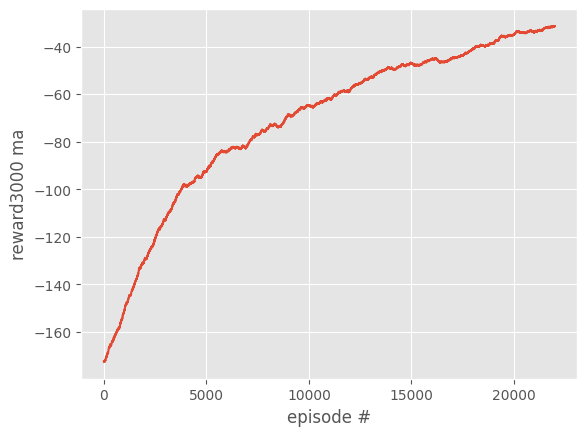

In [5]:
SIZE = 10  # 10x10 grid player, food, enemy will be initalize at random location at 10x10 grids
HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25

epsilon = 0.9 # will change with time
EPS_DECAY = 0.9998
SHOW_EVERY = 3000

start_q_table = None #or filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

d = {1: (255, 175, 0),   # bgr color
    2: (0, 255,0),
    3: (0,0,255)}

class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    def __str__(self):
        return f"{self.x}, {self.y}"   # Print the blob location
    def __sub__(self, other):  # define other blob and strubstract it from the other blob
        return (self.x - other.x, self.y - other.y)
    def action(self, choice):  # can only move diagonaly
        if choice == 0:
            self.move(x=1, y= 1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y
            
        if self.x <0:
            self.x = 0
        elif self.x > SIZE-1: # size 10 but positions 0 through 9
            self.x = SIZE-1
        if self.y <0:
            self.y = 0
        elif self.y > SIZE-1: 
            self.y = SIZE-1

if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1,y1), (x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

episode_rewards= []
for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    if episode % SHOW_EVERY ==0:
        print(f"on # {episode}, epsilon:{epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        if np.random.random()>epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,4)
        player.action(action)
        # enemy.move()
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y ==food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE*(reward+DISCOUNT*max_future_q)
        q_table[obs][action] = new_q
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[food.y][food.x] = d[FOOD_N]
            env[player.y][player.x] = d[PLAYER_N]
            env[enemy.y][enemy.x] = d[ENEMY_N]
            img = Image.fromarray(env,"RGB")
            img = img.resize((300,300))
            cv2.imshow("", np.array(img))
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
                if cv2.waitKey(500) & 0xFF== ord("q"):
                    break
            else:
                if cv2.waitKey(1) & 0xFF== ord("q"):
                    break
        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode="valid")
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward{SHOW_EVERY} ma")
plt.xlabel("episode #")
plt.show()

with open(f"q_table-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table,f)

In [6]:
env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
env[food.y][food.x] = d[FOOD_N]
env[player.y][player.x] = d[PLAYER_N]
env[enemy.y][enemy.x] = d[ENEMY_N]
env

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0],
        [255, 175,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0, 